# Module 2 Project - Housing Price Regression

## Scope and Business Understanding
I will be building a multivariate regression on the KC Housing Dataset with the goal of predicting house sale price as accurately as possible. This exercise will be completed in the context of a private equity / real estate investment firm looking for diligence and valuation support. Ideally, this regression will help identify statistically significant variables to target during due diligence processes to ensure time is spent researching aspects of a house that are meaningful to price. Additionally, if the data supports it, firms will be able to leverage this data to determine which potential future projects might be correlated with higher sales prices to guide renovation work. Ultimately, using the tool for buyers and sellers, this tool can be used to minimize risk and help improve return realization. 

I will aim to answer the following three primary questions:
1. What does the current KC housing market look like and what do the majority of houses have in common
2. Are there specific times (years, months, days) that might be related with a higher sale price?
3. Are provided rankings (grade, condition, etc.) trustworthy and are they actually relevant to predicting sale price?

## Overview of Process:
General process steps are as followed:
1. Load dataset and handle data issues (missing values, weird values, column data types, etc.)
2. Identify continuous, ordinal categorical, and non-ordinal categorical variables
3. Drop continuous variables that do not meet linearity requirements
4. Handle multi-collinearity amongst predictors
5. Handle categorical variables - treat ordinal categorical variables as single columns and encode non-ordinal categorical columns
6. Use stepwise selection to select features that meet p-value thresholds 
7. Run baseline model with these features 
8. Evaluate regression diagnostics and check assumptions
9. Continue preprocessing / transforming to improve results

## Data Understanding

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
%matplotlib inline

In [2]:
# set style of graphs and visualizations
plt.style.use('ggplot')

In [3]:
# import raw dataset
raw_df = pd.read_csv('kc_house_data.csv')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# drop id column as not relevant to analysis
clean_df = raw_df.drop('id', axis=1)

In [5]:
# check for missing values
clean_df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

We can see we are missing values in three columns - waterfront, yr_renovated, and view, with far more missing out of waterfront and yr_renovated.

In [6]:
# calc percentage of data missing
waterfront_missing = round(clean_df['waterfront'].isna().sum() / len(clean_df), 4)
yr_renovated_missing = round(clean_df['yr_renovated'].isna().sum() / len(clean_df), 4)
view_missing = round(clean_df['view'].isna().sum() / len(clean_df), 4)

# print percentages
print(f'Missing waterfront values comprise {waterfront_missing * 100}% of total data')
print(f'Missing yr_renovated values comprise {yr_renovated_missing * 100}% of total data')
print(f'Missing view values comprise {view_missing * 100}% of total data')

Missing waterfront values comprise 11.0% of total data
Missing yr_renovated values comprise 17.79% of total data
Missing view values comprise 0.29% of total data


In [7]:
# explore other values in these columns
print('waterfront')
display(clean_df['waterfront'].unique())
print('yr_renovated')
display(clean_df['yr_renovated'].unique())
print('view')
display(clean_df['view'].unique())

waterfront


array([nan,  0.,  1.])

yr_renovated


array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989.,
       2004., 1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971.,
       1979., 1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008.,
       1968., 2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955.,
       1982., 1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957.,
       1959., 1960., 1967., 1965., 1934., 1972., 1944., 1958.])

view


array([ 0., nan,  3.,  4.,  2.,  1.])

Looking at the value distribution for the three columns with missing values, can see the following:
* waterfront: only two other values, either 0 or 1. Missing values are likely instances where waterfront=0
* yr_renovated: 0 values refer to non-renovated houses.  Missing values are likely the same
* view: 5 other classes of view

Given these observations, the missing values will be handled in the following manner:
* waterfront: NaNs assigned value of 0
* yr_renovated: NaNs assigned value of 0
* view: NaNs assigned value of column median

In [8]:
# handle missing values
clean_df['waterfront'] = clean_df['waterfront'].fillna(value=0.)
clean_df['yr_renovated'] = clean_df['yr_renovated'].fillna(value=0.)
clean_df['view'] = clean_df['view'].fillna(value=clean_df['view'].median())

In [9]:
# check for duplicates
clean_df.duplicated().sum()

0

We have handled missing values and there are no duplicated entries.  Will move on to checking column types.

In [10]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  float64
 8   view           21597 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

All columns are numeric except for date and sqft_basement which are of type object. These will need to be addressed. 

In [11]:
# check sqft_basement
clean_df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2850.0        1
1852.0        1
1024.0        1
1816.0        1
1930.0        1
Name: sqft_basement, Length: 304, dtype: int64

Looking at value counts, there are entries with the value ?. Given there are only 454 of these, we will remove them from the dataset. 

In [12]:
# drop ? values from sqft_basement
clean_df = clean_df.loc[clean_df['sqft_basement'] != '?']

# convert back to number format
clean_df['sqft_basement'] = clean_df['sqft_basement'].astype('float')

In [13]:
# convert date column to datetime and then split into year, month, day
clean_df['date'] = pd.to_datetime(clean_df['date'], infer_datetime_format=True)
clean_df['year'] = clean_df['date'].map(lambda x: x.year)
clean_df['month'] = clean_df['date'].map(lambda x: x.month)
clean_df['day'] = clean_df['date'].map(lambda x: x.day)

# drop initial date column
clean_df = clean_df.drop('date', axis=1)

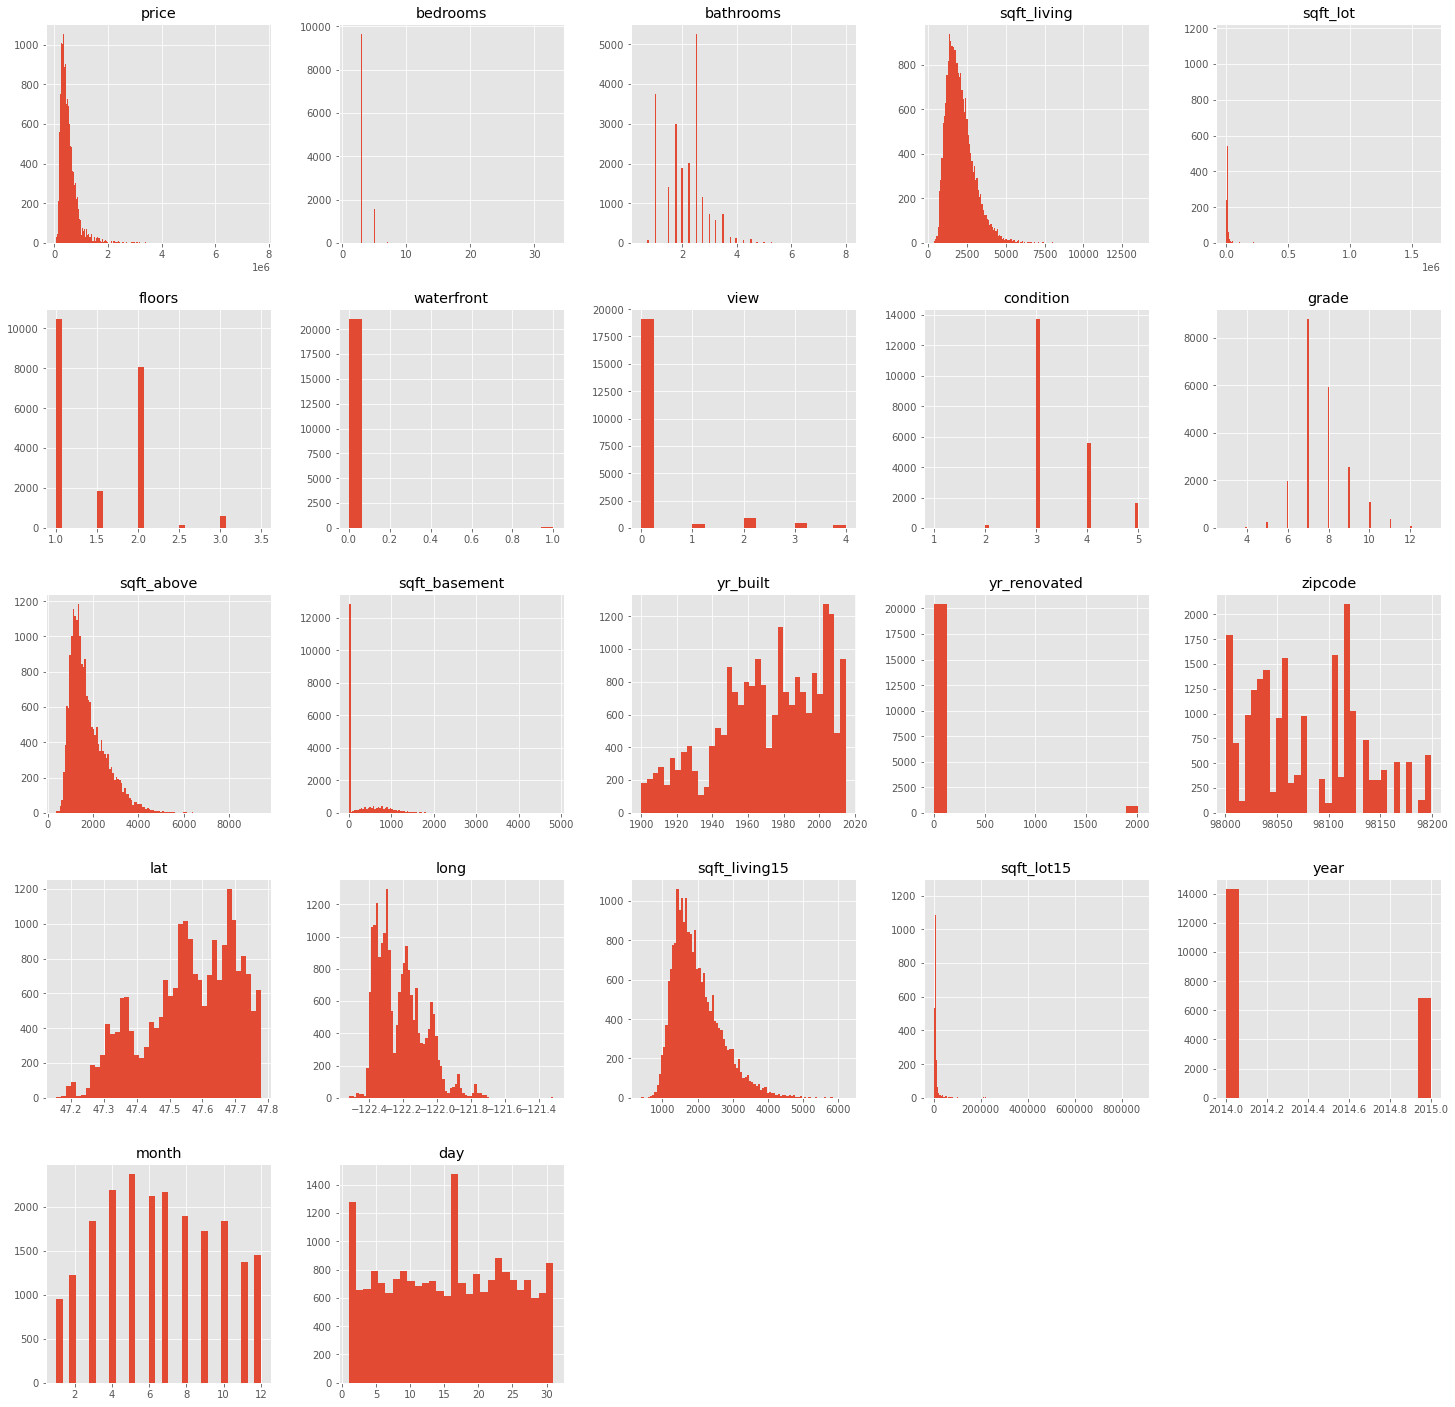

In [14]:
# explore distributions - histograms of each column
clean_df.hist(figsize=(25, 25), bins='auto')
plt.show()

In [15]:
# produce summary statistics
clean_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
count,2.114300e+04,21143.000000,21143.000000,21143.000000,2.114300e+04,21143.000000,21143.000000,21143.000000,21143.000000,21143.000000,...,21143.000000,21143.000000,21143.000000,21143.000000,21143.000000,21143.00000,21143.000000,21143.000000,21143.000000,21143.000000
mean,5.405107e+05,3.372558,2.116079,2080.920730,1.508714e+04,1.493591,0.006716,0.232654,3.409923,7.658279,...,1971.023223,68.256492,98077.868893,47.560274,-122.213876,1987.27139,12738.941967,2014.323417,6.574658,15.687698
std,3.680751e+05,0.924917,0.768531,918.547562,4.120920e+04,0.539249,0.081679,0.764064,0.650498,1.174253,...,29.321938,362.765827,53.535756,0.138591,0.140597,685.67034,27169.273663,0.467791,3.115428,8.632494
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,...,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.00000,651.000000,2014.000000,1.000000,1.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.043000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,...,1952.000000,0.000000,98033.000000,47.471250,-122.328000,1490.00000,5100.000000,2014.000000,4.000000,8.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,...,1975.000000,0.000000,98065.000000,47.572000,-122.230000,1840.00000,7626.000000,2014.000000,6.000000,16.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,...,1997.000000,0.000000,98117.000000,47.678200,-122.125000,2360.00000,10087.000000,2015.000000,9.000000,23.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,...,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.00000,871200.000000,2015.000000,12.000000,31.000000


 - bathrooms: appears to be categorical with the majority of entries falling between 0.5 and 3 bathrooms. there are a number of outliers to the right, with one entry having 8 bedrooms.  Room to clean these outliers up after the baseline model is generated.  Summary stats presented above, shows a median of 2.25 bathrooms, and a standard deviation of just over 0.75 bathrooms
 - bedrooms: appears to be categorical with the majority of entries having 1 to 4 bedrooms.  Significant oulier with one entry having 33 bedrooms.  Median number of bedrooms is 3, with a standard deviation of just under 1 bedroom
 - condition: appears categorical, max of 5, median of 3 - - looks like the majority are condition ratings of 3 and 4.  standard deviation of 0.65 (just over half one condition rating)
 - day_sold: appears to be categorical.  Looks like there is no deviation other than near the beginning of the month (day 1) and the middle of the month (day ~20) showing more houses sold near these days than on others
 - floors: categorical with a significant falloff after 2 floors
 - grade: appears somewhat normally distributed although it is categorical.  Some grades above 10, with the most between 6 and 9.  Median grade is 7 with a std of 1.17
 - month_sold: categorical, but interesting to see that there are more houses sold during the summer months than winter months, which makes sense
 - price, sqft_above, sqft_living, sqft_living15 appear log normally distributed, with right skew and likely some positive outliers
 - sqft_lot and sqft_lot15 have have significant right skew and outliers
 - view: very few houses have been viewed (> 0 value)
 - waterfront: very few houses have waterfront
 - year_sold: only two years of sale data is included here (2014 and 2015), with more entries coming from 2014 than 2015
 - yr_built: the majority of houses represented were built after 1950, with the earliest house included being built in 1900
 - yr_renovated: only a handful have received renovations

In [16]:
def plot_viz(data, target, predictors, nrows=1, ncols=1, figsize=(10, 4)):
    """
    Function to plot y vs. a chosen set of x variables: includes regression line
    Parameters:
        data: name of dataframe variables are coming from
        target: string of target variable
        predictors: dataframe of predictors
        nrows: number of rows of subplots
        ncols: number of cols of subplots
        figsize: size of the figure
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for ax, feature in zip(axes.flatten(), predictors):
        sns.regplot(x=feature, y=target, data=data, ax=ax, scatter_kws={'alpha':0.2});
        ax.set_title(f'{feature} vs. {target}')
    plt.tight_layout()

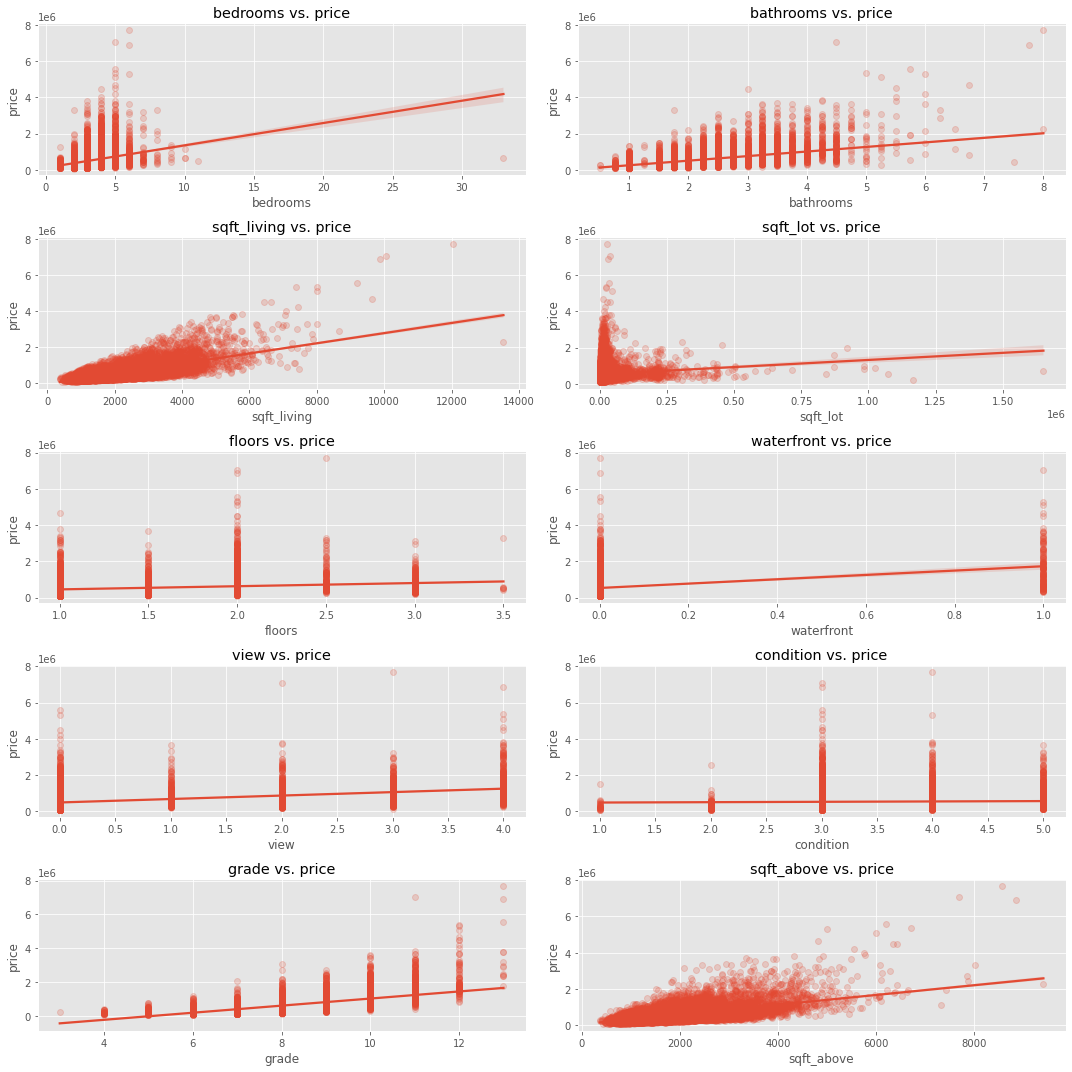

In [17]:
# evaluate relationship between variables and price
predictors = clean_df.drop('price', axis=1)
plot_viz(data=clean_df,
         target='price',
         predictors=predictors,
         nrows=5,
         ncols=2,
         figsize=(15, 15))

As can be seen when plotting against price, there are a number of price outliers seen in the data - - looking at the distribution of price will allow us to see this better - - start with price as it is our target variable. Going to divide by 1000 when plotting to allow the axis to be seen easier.

/Users/addingtongraham/opt/anaconda3/envs/keras-env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


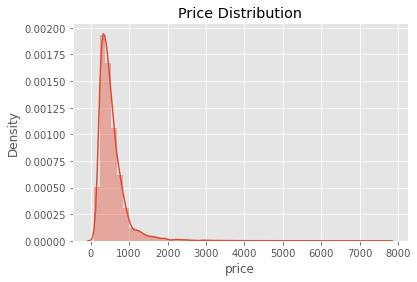

In [18]:
# look at just the distribution of price
scaled_price = clean_df['price'] / 1000
sns.distplot(scaled_price)
plt.title('Price Distribution')
plt.show()

When looking at the distribution of price there is clear right skew - we will attempt to clean this up after our baseline model. Not transforming prior to baseline because I want something to compare all subsequent changes to.

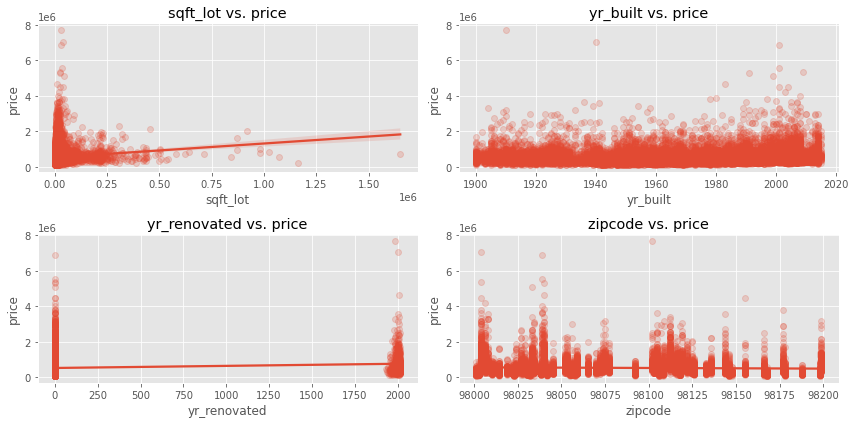

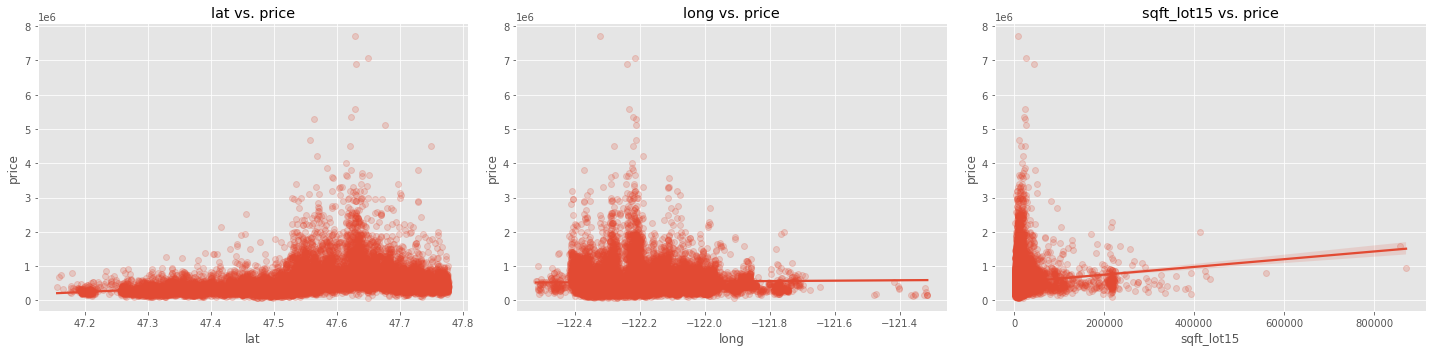

In [19]:
non_linear_1 = ['sqft_lot', 'yr_built', 'yr_renovated', 'zipcode']
non_linear_2 = ['lat', 'long', 'sqft_lot15']

predictors1 = clean_df[non_linear_1]
predictors2 = clean_df[non_linear_2]

# replot non-linear against price to show these violate the assumptions
plot_viz(data=clean_df,
         target='price',
         predictors=predictors1,
         nrows=2,
         ncols=2,
         figsize=(12, 6))

plot_viz(data=clean_df,
         target='price',
         predictors=predictors2,
         nrows=1,
         ncols=3,
         figsize=(20, 5))

From these plots against price, its clear there are number of variables that do not meet the linearity assumption.  Drop `yr_built`, `yr_renovated`, `zipcode`, `lat`, `long` for violating linearity assumptions.

In [20]:
# drop non-linear
preprocessed = clean_df.drop(['yr_built', 'yr_renovated', 'zipcode',
                              'lat', 'long'], axis=1)

In [21]:
def multi_collinearity(data_pred, percent_correlated=0.75):
    """
    Function to identify multi-collinearity based on a threshold value.
    Parameters:
        data_pred: predictor variables
        percent_correlated: threshold percentage to determine the level of correlation to identify
    Returns: Dataframe of correlated pairs, with duplicates removed
    """
    
    df = data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    
    # zip the variable name columns (named level_0 and level_1 by default) in a new column named "pairs"
    df['pairs'] = list(zip(df.level_0, df.level_1))
    
    # set index to pairs
    df.set_index(['pairs'], inplace=True)
    
    # drop level columns
    df.drop(columns=['level_1', 'level_0'], inplace=True)
    
    # rename correlation column as cc rather than 0
    df.columns = ['cc']
    
    # drop duplicates
    df.drop_duplicates(inplace=True)
    
    return df[(df.cc > percent_correlated) & (df.cc < 1)]

Now that non-linear predictors have been removed, use `multi_collinearity(data_pred, 0.75)` to get all predictors that are 75% or more correlated.

In [22]:
# identify and remove multi-collinearity
data_pred = preprocessed.drop('price', axis=1)
correlated_predictors = multi_collinearity(data_pred, 0.75)
correlated_predictors

,cc
pairs,
"(sqft_above, sqft_living)",0.876678
"(month, year)",0.782154
"(grade, sqft_living)",0.763101
"(sqft_living, sqft_living15)",0.756389
"(grade, sqft_above)",0.756382
"(sqft_living, bathrooms)",0.755278


In [23]:
# remove multi-correlated predictors
preprocessed = preprocessed.drop('sqft_living', axis=1)

Now that non-linear continuous columns and multicollinearity has been removed, start handling categorical variables.  For the baseline model, only going to separate out ordinal from non-ordinal and one-hot enncode non-ordinal.

Visualize relationships by plotting boxplots vs. price - - this will help show if there is any pattern / ordinal relationship.

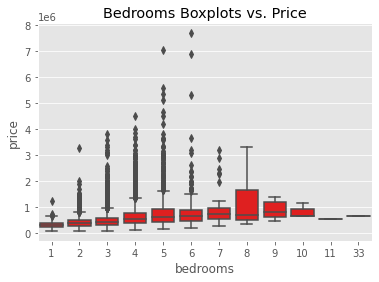

In [24]:
# bedrooms
sns.boxplot(x='bedrooms', y='price', data=preprocessed, color='red')
plt.title('Bedrooms Boxplots vs. Price')
plt.show()

The price outliers are very apparent in this plot - will continue to leave these in for the baseline. Additionally, it appears that there is somewhat of an ordinal relationship here so bedrooms will be left in as a single column and not one-hot encoded

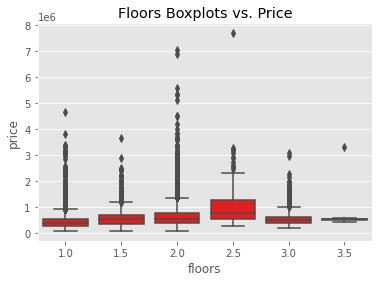

In [25]:
# floors
sns.boxplot(x='floors', y='price', data=preprocessed, color='red')
plt.title('Floors Boxplots vs. Price')
plt.show()

There is no clear ordinal relationship here so will keep treating this as a categorical column and eventually one-hot encode.  smf.ols runs into some syntax issues when trying to use column names ending in `.0`.  For this reason, scale floors by 10 and then convert to an int type. 

Create a running list of all variables that need to be one-hot encoded in `ohe_list`

In [26]:
# scale by 10 to prevent issues with sms.ols later
preprocessed['floors_10'] = preprocessed['floors'] * 10

# convert to int
preprocessed['floors_10'] = preprocessed['floors_10'].astype('int64')

# add to ohe_list
ohe_list = []
ohe_list.append('floors_10')

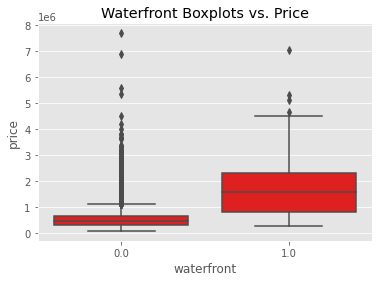

In [27]:
# waterfront
sns.boxplot(x='waterfront', y='price', data=preprocessed, color='red');
plt.title('Waterfront Boxplots vs. Price')
plt.show()

Looking at this, again there are clearly price outliers, but ignoring those, it looks like having waterfront is related to higher priced homes.  This is still muddy given all the noise from outliers, etc. but from a first glance there appears to be a relationship between waterfront and price. 

Add to `ohe_list` and translate column to int type.

In [28]:
# convert to int column
preprocessed['waterfront'] = preprocessed['waterfront'].astype('int64')

# append to ohe_list
ohe_list.append('waterfront')

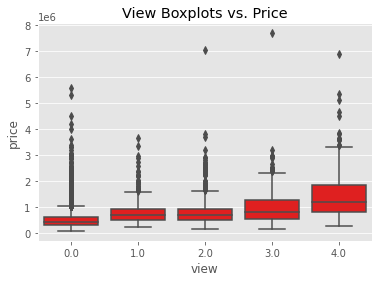

In [29]:
# view
sns.boxplot(x='view', y='price', data=preprocessed, color='red');
plt.title('View Boxplots vs. Price')
plt.show()

Looking at the boxplots / median lines there appears to be a somewhat ordinal relationship between price and view. As a result, for the baseline model, this will be kept as a single column

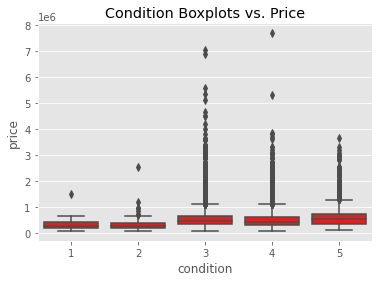

In [30]:
# condition
sns.boxplot(x='condition', y='price', data=preprocessed, color='red');
plt.title('Condition Boxplots vs. Price')
plt.show()

While outliers makes it hard to see, there is no clear ordinal relationship here.  As a result, append `condition` to the `ohe_list`.  No need to transform column type as it is already type int

In [31]:
ohe_list.append('condition')

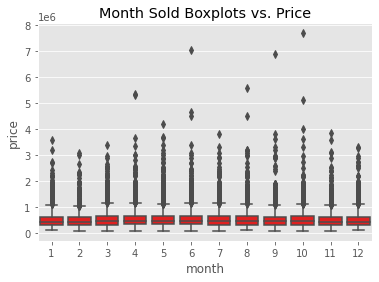

In [32]:
# month_sold
sns.boxplot(x='month', y='price', data=preprocessed, color='red');
plt.title('Month Sold Boxplots vs. Price')
plt.show()

No clear ordinal relationship, add to `ohe_list`

In [33]:
ohe_list.append('month')

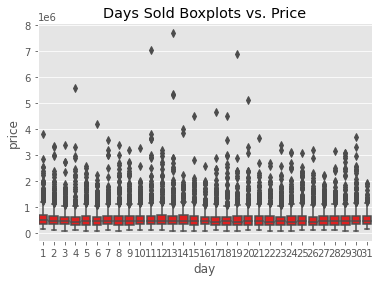

In [34]:
# days_sold
sns.boxplot(x='day', y='price', data=preprocessed, color='red');
plt.title('Days Sold Boxplots vs. Price')
plt.show()

No clear ordinal relationship, add to `ohe_list`

In [35]:
ohe_list.append('day')

Create dummy variables for each categorical column that was determined to not be ordinal. Then drop ohe_list from the dataset.

In [36]:
# create dummy variables
floors_dummies = pd.get_dummies(preprocessed['floors_10'], 
                                prefix='floors', 
                                drop_first=True)

waterfront_dummies = pd.get_dummies(preprocessed['waterfront'], 
                                    prefix='waterfront', 
                                    drop_first=True)

condition_dummies = pd.get_dummies(preprocessed['condition'],
                                   prefix='condition',
                                   drop_first=True)

month_sold_dummies = pd.get_dummies(preprocessed['month'],
                                   prefix='month',
                                   drop_first=True)

day_sold_dummies = pd.get_dummies(preprocessed['day'],
                                  prefix='day',
                                  drop_first=True)

In [37]:
# drop columns
data_fin = preprocessed.drop(['floors', 'floors_10', 
                              'waterfront', 'condition', 
                              'month', 'day'], axis=1)

Set up final dataset for feature selection and to run the baseline regression. Concat remaining columns with the dummy variables and then run feature selection.

In [38]:
# concat with dummies
data_fin = pd.concat([data_fin,
                      floors_dummies,
                      waterfront_dummies,
                      condition_dummies,
                      month_sold_dummies,
                      day_sold_dummies], axis=1)

## Baseline Model

In [39]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """
    Function to perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS
    Parameters:
        X: pandas.Dataframe with candidate features
        y: list-like with the target
        initial_list: list of features to start with (column names of X)
        threshold_in: include a feature if its p-val < threshold_in
        threshold_out: exclude a feature if its p-val > threshold_out
        verbose: whether to print the sequence of inclusions and exclusions
    Returns: list of selected features
    Note: always set threshold_in < threshold_out to avoid infinite looping
    """
    included = list(initial_list)
    while True:
        changed=False
        
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [40]:
# run stepwise selection to select features
y = data_fin['price']
X = data_fin.drop('price', axis=1)
result = stepwise_selection(X, y, verbose=True)

Add  sqft_basement                  with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  grade                          with p-value 0.0
Add  waterfront_1                   with p-value 0.0
Add  view                           with p-value 5.13578e-163
Add  floors_20                      with p-value 2.5826e-92
Add  condition_5                    with p-value 2.07907e-63
Add  bedrooms                       with p-value 5.37279e-52
Add  floors_15                      with p-value 1.29203e-39
Add  sqft_lot15                     with p-value 4.51141e-39
Add  condition_3                    with p-value 4.17438e-26
Add  floors_25                      with p-value 5.99118e-19
Add  year                           with p-value 1.71969e-13
Add  sqft_living15                  with p-value 3.34965e-07
Add  month_2                        with p-value 2.13077e-06
Add  floors_30                      with p-value 9.5623e-05
Add  day_13                         with p-value 0.001300

Take the predictors that were returned by the feature selection.  Make sure to add constant as sm.OLS does not include this. Fit the model against and the predictors + constant.  Print model summary to evaluate baseline

In [41]:
# run regression with these features
X = data_fin[result]
y = data_fin['price']
predictors = sm.add_constant(X)
model = sm.OLS(y, predictors).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     1926.
Date:                Thu, 10 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:01:50   Log-Likelihood:            -2.9070e+05
No. Observations:               21143   AIC:                         5.814e+05
Df Residuals:                   21124   BIC:                         5.816e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.179e+07    7.2e+06     -8.577      0.000   -7.59e+07   -4.77e+07
sqft_basement   202.0701      4.493     44.971      0.000     193.263     210.877
sqft_above      185.8707      3.987     46.615      0.000     178.055     193.686
grade          1.041e+05   2352.103     44.252      0.000    9.95e+04    1.09e+05
waterfront_1    6.26e+05   2.07e+04     30.294      0.000    5.86e+05    6.67e+05
view           5.711e+04   2370.009     24.096      0.000    5.25e+04    6.18e+04
floors_20     -4.959e+04   4558.102    -10.879      0.000   -5.85e+04   -4.07e+04
condition_5    7.396e+04   6350.900     11.645      0.000    6.15e+04    8.64e+04
bedrooms      -3.863e+04   2127.013    -18.161      0.000   -4.28e+04   -3.45e+04
floors_15      8.359e+04   5854.889     14.277      0.000    7.21e+04    9.51e+04
sqft_lot15       -0.7957      0.059    -13.373      0.000      -0.912      -0.679
condition_3   -4.212e+04   3770.770    -11.170      0.000   -4.95e+04   -3.47e+04
floors_25      1.796e+05   1.87e+04      9.608      0.000    1.43e+05    2.16e+05
year           3.041e+04   3576.593      8.502      0.000    2.34e+04    3.74e+04
sqft_living15    21.7681      3.820      5.698      0.000      14.281      29.256
month_2       -3.391e+04   7171.810     -4.729      0.000    -4.8e+04   -1.99e+04
floors_30       3.97e+04   1.01e+04      3.914      0.000    1.98e+04    5.96e+04
day_13         2.838e+04   8604.513      3.298      0.001    1.15e+04    4.52e+04
day_30         2.447e+04   9383.010      2.608      0.009    6080.257    4.29e+04
==============================================================================
Omnibus:                    15278.755   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           918246.267
Skew:                           2.883   Prob(JB):                         0.00
Kurtosis:                      34.766   Cond. No.                     1.39e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

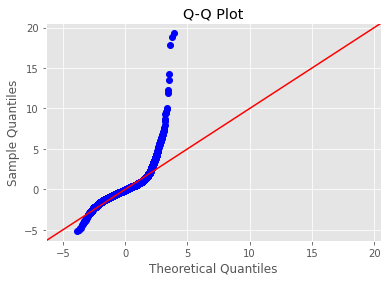

In [42]:
# plot q-q check normality of residuals for baseline
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True);
plt.title('Q-Q Plot');

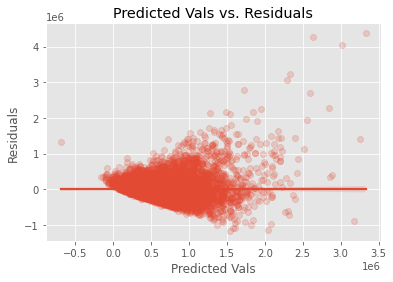

In [43]:
# check heteroscedascity for baseline
predicted_vals = model.predict(predictors)
sns.regplot(x=predicted_vals, y=model.resid, scatter_kws={'alpha': 0.2});
plt.title('Predicted Vals vs. Residuals')
plt.xlabel('Predicted Vals')
plt.ylabel('Residuals');

Based on the above Q-Q plots and residual plot, we can see that our assumptions for normally distributed residuals does not hold.  Additionally, there appears to be some pattern in the residual plot, highlighting the presence of heteroscedasticity, another violation of a regression assumption.  We will continue to preprocess to try and improve results. 

# Model Iteration

Now that we have a baseline in place, we can start trying to improve our results against the baseline.  This shouldn't be too difficult given how messy our plots against and residual plots were looking.  To begin, we will revert back to `clean_df` which includes our initial clean up changes to fix missing values and erroneous values, etc.

In the next two models, I will be focusing on transforming only the target variable to see if that improves linearity and residual normality / homoscedasticity using a log transformation.

In terms of process, first make price transformations, repeat steps from baseline model, and re-evaluate results and see if assumptions for regression are looking better.

In [44]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21143 non-null  float64
 1   bedrooms       21143 non-null  int64  
 2   bathrooms      21143 non-null  float64
 3   sqft_living    21143 non-null  int64  
 4   sqft_lot       21143 non-null  int64  
 5   floors         21143 non-null  float64
 6   waterfront     21143 non-null  float64
 7   view           21143 non-null  float64
 8   condition      21143 non-null  int64  
 9   grade          21143 non-null  int64  
 10  sqft_above     21143 non-null  int64  
 11  sqft_basement  21143 non-null  float64
 12  yr_built       21143 non-null  int64  
 13  yr_renovated   21143 non-null  float64
 14  zipcode        21143 non-null  int64  
 15  lat            21143 non-null  float64
 16  long           21143 non-null  float64
 17  sqft_living15  21143 non-null  int64  
 18  sqft_l

Start by looking at the distribution of price and see how that will change with the different transformations.

/Users/addingtongraham/opt/anaconda3/envs/keras-env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


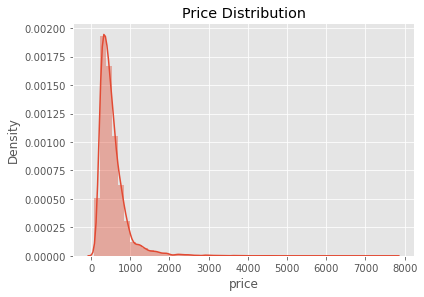

In [45]:
# price distribution
sns.distplot(clean_df['price']/1000)
plt.tight_layout()
plt.title('Price Distribution')
plt.show()

We can see that there is significant right skew and there appear to be a number of outliers to the right.  This looks like it would benefit from log transformation, so we will begin with that.

In [46]:
# log transform
clean_df['log_price'] = np.log(clean_df['price'])

/Users/addingtongraham/opt/anaconda3/envs/keras-env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_price', ylabel='Density'>

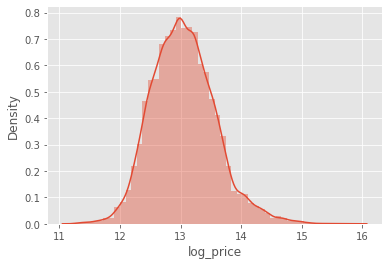

In [47]:
# plot log_price
sns.distplot(clean_df['log_price'])

From visual inspection, can see our target variable is far more normally distributed now. 

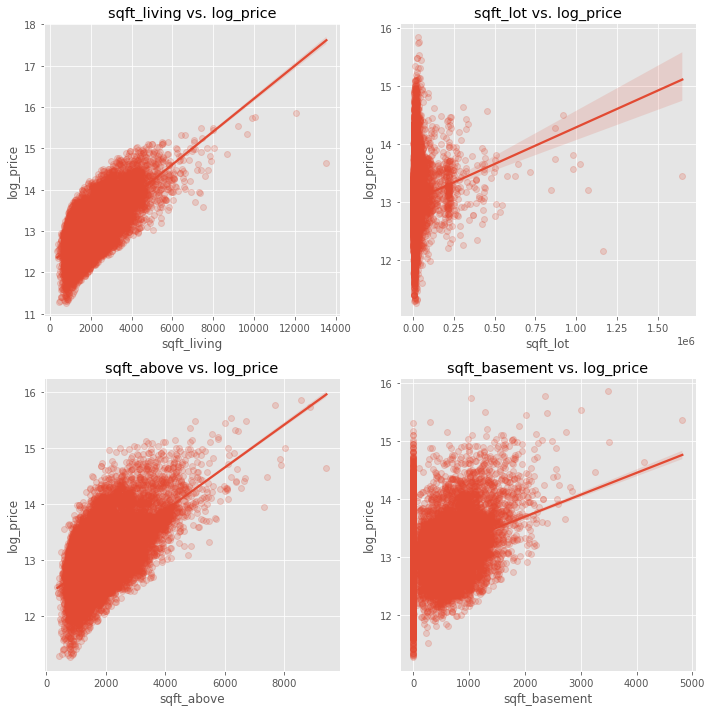

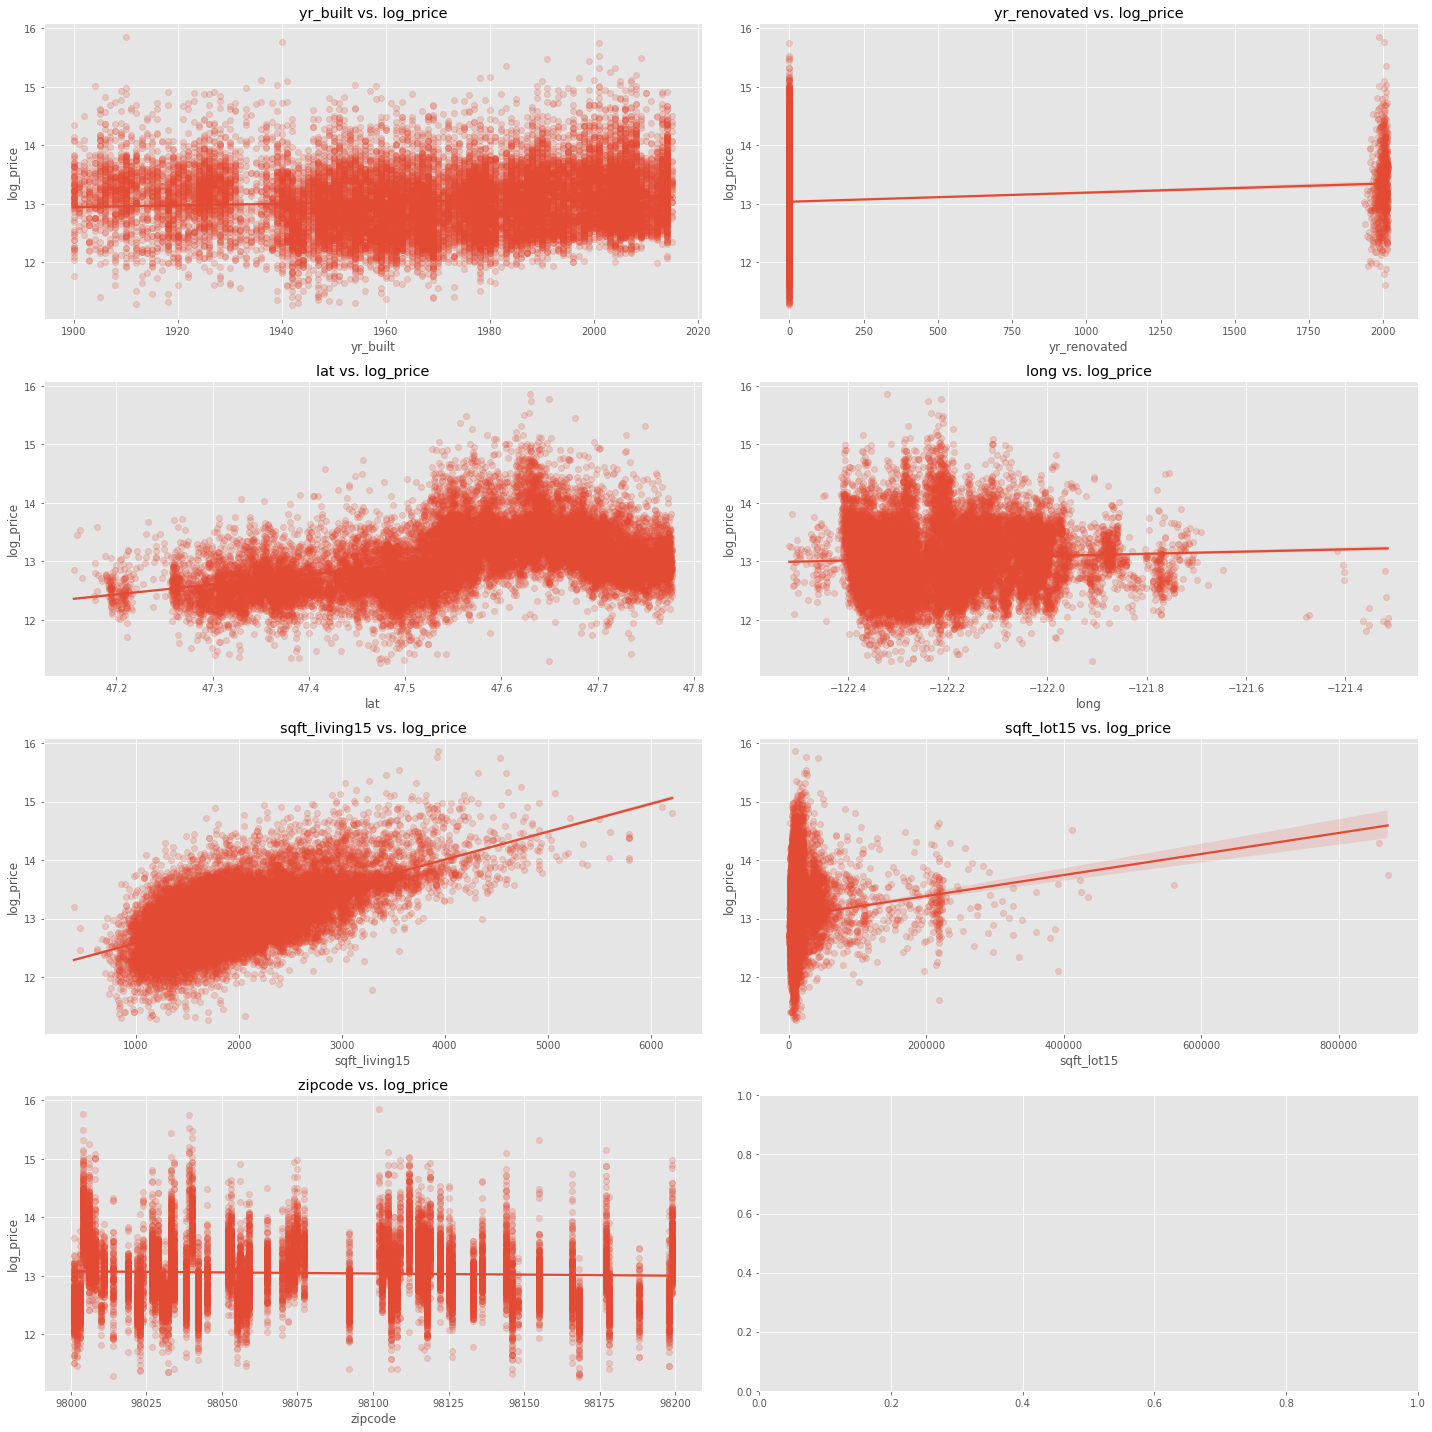

In [48]:
# plot continuous against price
variables = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
variables_2 = ['yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'zipcode']

plot_viz(data=clean_df,
         target='log_price',
         predictors=variables,
         nrows=2,
         ncols=2,
         figsize=(10, 10))

plot_viz(data=clean_df,
         target='log_price',
         predictors=variables_2,
         nrows=4,
         ncols=2,
         figsize=(20, 20))

Variables are showing more linear relationships when plotted against log transformed price.  Continue with dropping non-linear columns.

In [49]:
# drop predictors that violate linearity assumptions
preprocessed = clean_df.drop(['yr_built', 'zipcode', 'lat', 'long'], axis=1)

In [50]:
# identify and remove any multi-collinearity
data_pred = preprocessed.drop('log_price', axis=1)
correlated_predictors = multi_collinearity(data_pred, 0.75)
correlated_predictors

,cc
pairs,
"(sqft_above, sqft_living)",0.876678
"(month, year)",0.782154
"(grade, sqft_living)",0.763101
"(sqft_living15, sqft_living)",0.756389
"(sqft_above, grade)",0.756382
"(sqft_living, bathrooms)",0.755278


In [51]:
# drop sqft_living
preprocessed = preprocessed.drop(['sqft_living', 'year'], axis=1)
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21143 non-null  float64
 1   bedrooms       21143 non-null  int64  
 2   bathrooms      21143 non-null  float64
 3   sqft_lot       21143 non-null  int64  
 4   floors         21143 non-null  float64
 5   waterfront     21143 non-null  float64
 6   view           21143 non-null  float64
 7   condition      21143 non-null  int64  
 8   grade          21143 non-null  int64  
 9   sqft_above     21143 non-null  int64  
 10  sqft_basement  21143 non-null  float64
 11  yr_renovated   21143 non-null  float64
 12  sqft_living15  21143 non-null  int64  
 13  sqft_lot15     21143 non-null  int64  
 14  month          21143 non-null  int64  
 15  day            21143 non-null  int64  
 16  log_price      21143 non-null  float64
dtypes: float64(8), int64(9)
memory usage: 3.5 MB


Given the number of zeros on yr_renovated, going to translate this into a categorical column relating to whether a house has received a renovation or not.  Then, one-hot encode.

In [52]:
# create renovated column
preprocessed['renovated'] = preprocessed['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)

# drop yr_renovated column
preprocessed.drop('yr_renovated', axis=1, inplace=True)

Start handling categorical columns similar to what we did in the baseline model

In [53]:
# evaluate and handle categorical columns
# create boxplots for all cat columns --  see if price transformations have helped
# start with log
cat_cols = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 
            'grade', 'month', 'day', 'renovated']
cat_predictors = preprocessed[cat_cols]

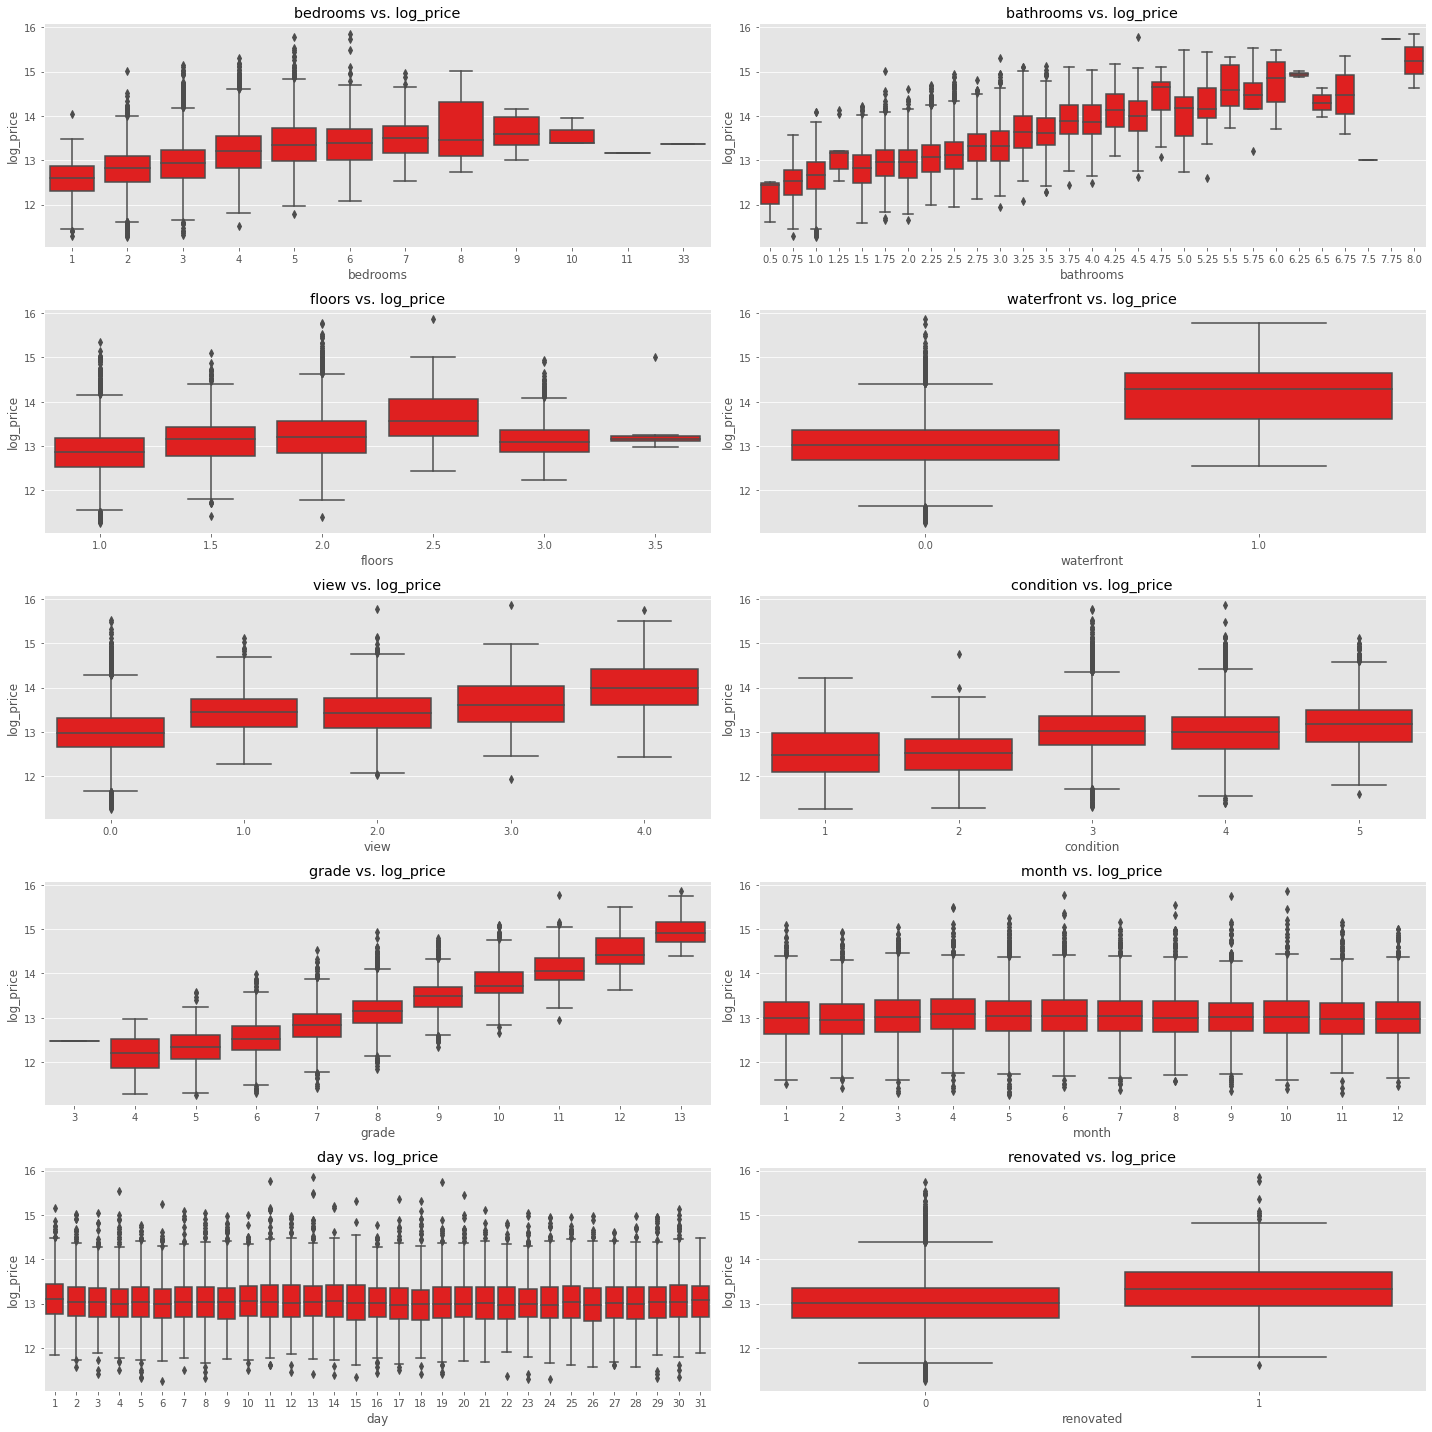

In [54]:
# plot boxplots of all cat columns vs. log_price
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))
for ax, feature in zip(axes.flatten(), cat_predictors):
    sns.boxplot(x=feature, y='log_price', data=preprocessed, ax=ax, color='red');
    ax.set_title(f'{feature} vs. log_price')
    
plt.tight_layout()

Looking at the above boxplots plotted against price, it is hard to identify a clear relationship with time of year and sale price, but let's zoom in on month_sold to see if any relationship is clear

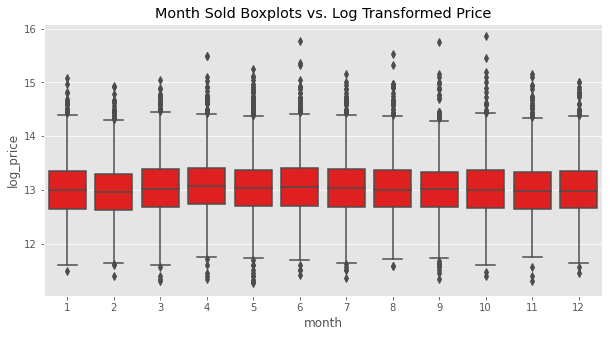

In [55]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='month', y='log_price', data=preprocessed, color='red')
plt.title('Month Sold Boxplots vs. Log Transformed Price')
plt.show()

There appears to be a slight benefit to selling in the spring months - - looking at the above plot, month 3, 4, and 5 seem to be correlated with higher median sale price

Looking at boxplots of grade and condition vs. price, we can see that houses with both high grades and high condition scores appear correlated with higher house sale prices. 

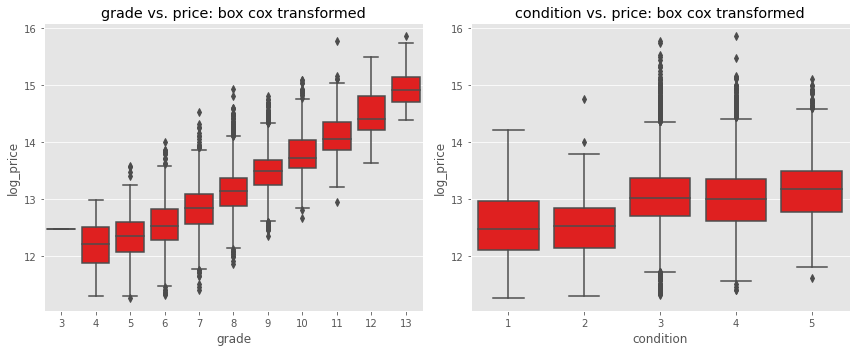

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
variables = preprocessed[['grade', 'condition']]

for ax, feature in zip(axes.flatten(), variables):
    sns.boxplot(x=feature, y='log_price', data=preprocessed, ax=ax, color='red')
    ax.set_title(f'{feature} vs. price: box cox transformed')
    
plt.tight_layout()

Looking at grade, we see an ordinal relationship, with a clear positive relationship between higher grades and higher sale price.  Similarly, while not as obvious, higher condition scores seem to be correlated with higher sale price.  Looking at the above, one can see that condition scores 3, 4, 5 have median sale prices higher than those with condition scores of 1 and 2. 

In [57]:
ohe_list

['floors_10', 'waterfront', 'condition', 'month', 'day']

In [58]:
ordinal_cat_cols = ['bedrooms', 'bathrooms', 'grade']
ordinal_predictors = preprocessed[ordinal_cat_cols]

In [59]:
# clean up ohe columns to avoid syntax errors going forward

# floors
preprocessed['floors_10'] = preprocessed['floors'] * 10
preprocessed['floors_10'] = preprocessed['floors_10'].astype('int')
preprocessed.drop('floors', axis=1, inplace=True)

# waterfront
preprocessed['waterfront'] = preprocessed['waterfront'].astype('int')
preprocessed['view'] = preprocessed['view'].astype('int')

ohe_list = ['floors_10', 'waterfront', 'view', 'condition',
            'month', 'day', 'renovated']

In [60]:
# create dummy variables
floors_dummies = pd.get_dummies(preprocessed['floors_10'], prefix='floors', drop_first=True)
water_dummies = pd.get_dummies(preprocessed['waterfront'], prefix='water', drop_first=True)
view_dummies = pd.get_dummies(preprocessed['view'], prefix='view', drop_first=True)
condition_dummies = pd.get_dummies(preprocessed['condition'], prefix='condition', drop_first=True)
month_dummies = pd.get_dummies(preprocessed['month'], prefix='month', drop_first=True)
day_dummies = pd.get_dummies(preprocessed['day'], prefix='day', drop_first=True)
reno_dummies = pd.get_dummies(preprocessed['renovated'], prefix='reno', drop_first=True)

In [61]:
data_fin = preprocessed.drop(ohe_list, axis=1)

In [62]:
data_fin = pd.concat([data_fin, floors_dummies, water_dummies,
                      view_dummies, condition_dummies,
                      month_dummies, day_dummies, reno_dummies], axis=1)

In [63]:
# run stepwise selection to select features
y = data_fin['log_price']
X = data_fin.drop('log_price', axis=1)
result = stepwise_selection(X, y, verbose=True)

Add  sqft_basement                  with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  grade                          with p-value 0.0
Add  price                          with p-value 0.0
Drop sqft_above                     with p-value 0.191798
Add  floors_15                      with p-value 5.95469e-69
Add  sqft_living15                  with p-value 5.31825e-68
Add  water_1                        with p-value 4.0854e-61
Add  floors_20                      with p-value 2.61805e-27
Add  sqft_above                     with p-value 7.36938e-39
Add  floors_30                      with p-value 8.23357e-36
Add  condition_2                    with p-value 6.35141e-25
Add  condition_5                    with p-value 5.13393e-23
Add  bedrooms                       with p-value 1.91481e-20
Add  sqft_lot                       with p-value 5.10794e-11
Add  view_4                         with p-value 6.35239e-11
Add  reno_1                         with p-value 1.16635e-10

In [64]:
# run regression with these features
X = data_fin[result]
y = data_fin['log_price']
predictors = sm.add_constant(X)
model = sm.OLS(y, predictors).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     5550.
Date:                Thu, 10 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:03:36   Log-Likelihood:                 2485.6
No. Observations:               21143   AIC:                            -4931.
Df Residuals:                   21123   BIC:                            -4772.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            11.5678      0.020    572.333      0.000      11.528      11.607
sqft_basement  2.909e-05   4.45e-06      6.542      0.000    2.04e-05    3.78e-05
grade             0.0726      0.002     31.030      0.000       0.068       0.077
price          1.079e-06   6.53e-09    165.087      0.000    1.07e-06    1.09e-06
floors_15         0.1181      0.006     21.198      0.000       0.107       0.129
sqft_living15  8.061e-05   3.61e-06     22.339      0.000    7.35e-05    8.77e-05
water_1          -0.2525      0.022    -11.339      0.000      -0.296      -0.209
floors_20         0.0794      0.004     18.607      0.000       0.071       0.088
sqft_above     -6.58e-05   3.96e-06    -16.631      0.000   -7.36e-05    -5.8e-05
floors_30         0.1385      0.010     14.406      0.000       0.120       0.157
condition_5       0.2293      0.016     13.942      0.000       0.197       0.262
bedrooms          0.0194      0.002      9.546      0.000       0.015       0.023
sqft_lot       2.391e-07   3.71e-08      6.443      0.000    1.66e-07    3.12e-07
view_4           -0.0924      0.015     -6.043      0.000      -0.122      -0.062
reno_1            0.0574      0.008      6.921      0.000       0.041       0.074
condition_4       0.1856      0.016     11.741      0.000       0.155       0.217
month_4           0.0308      0.005      6.333      0.000       0.021       0.040
view_2            0.0336      0.007      4.543      0.000       0.019       0.048
condition_3       0.1632      0.016     10.383      0.000       0.132       0.194
view_1            0.0481      0.012      3.965      0.000       0.024       0.072
==============================================================================
Omnibus:                    16587.002   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1588555.304
Skew:                          -3.129   Prob(JB):                         0.00
Kurtosis:                      45.000   Cond. No.                     1.40e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

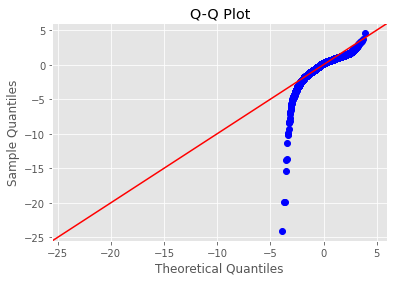

In [66]:
# check model residual plots and q-q check for normality of residuals
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title('Q-Q Plot')
plt.show()

Text(0, 0.5, 'Residuals')

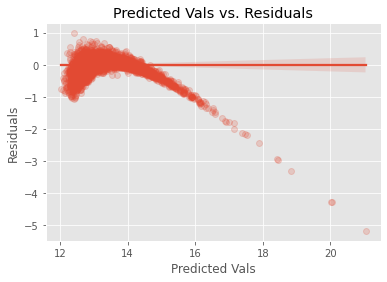

In [68]:
# check heteroscedascity
predicted_vals = model.predict(predictors)
sns.regplot(x=predicted_vals, y=model.resid, scatter_kws={'alpha': 0.2})
plt.title('Predicted Vals vs. Residuals')
plt.xlabel('Predicted Vals')
plt.ylabel('Residuals')

After iterating changes on our target variable, we can see that assumptions for linear regression are better but still being violated - - continue with additional iteration to see if we can improve results.

## Manipulation of Predictor Variables

In [69]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21143 non-null  float64
 1   bedrooms       21143 non-null  int64  
 2   bathrooms      21143 non-null  float64
 3   sqft_lot       21143 non-null  int64  
 4   waterfront     21143 non-null  int64  
 5   view           21143 non-null  int64  
 6   condition      21143 non-null  int64  
 7   grade          21143 non-null  int64  
 8   sqft_above     21143 non-null  int64  
 9   sqft_basement  21143 non-null  float64
 10  sqft_living15  21143 non-null  int64  
 11  sqft_lot15     21143 non-null  int64  
 12  month          21143 non-null  int64  
 13  day            21143 non-null  int64  
 14  log_price      21143 non-null  float64
 15  renovated      21143 non-null  int64  
 16  floors_10      21143 non-null  int64  
dtypes: float64(4), int64(13)
memory usage: 3.5 MB


In [ ]:
# pull out numerical columns
numerical = ['sqft_lot', 'sqft_']